            Date          Open          High           Low         Close  \
0     2018-02-28  10687.200195  11089.799805  10393.099609  10397.900391   
1     2018-03-01  10385.000000  11052.299805  10352.700195  10951.000000   
2     2018-03-02  10977.400391  11189.000000  10850.099609  11086.400391   
3     2018-03-03  11101.900391  11528.200195  11002.400391  11489.700195   
4     2018-03-04  11497.400391  11512.599609  11136.099609  11512.599609   
...          ...           ...           ...           ...           ...   
1822  2023-02-24  23946.007813  24103.705078  23007.072266  23198.126953   
1823  2023-02-25  23200.125000  23210.210938  22861.558594  23175.375000   
1824  2023-02-26  23174.150391  23654.367188  23084.220703  23561.212891   
1825  2023-02-27  23561.451172  23857.890625  23205.878906  23522.871094   
1826  2023-02-28  23521.837891  23585.384766  23077.650391  23147.353516   

         Adj Close       Volume  
0     10397.900391   6936189952  
1     10951.000000 

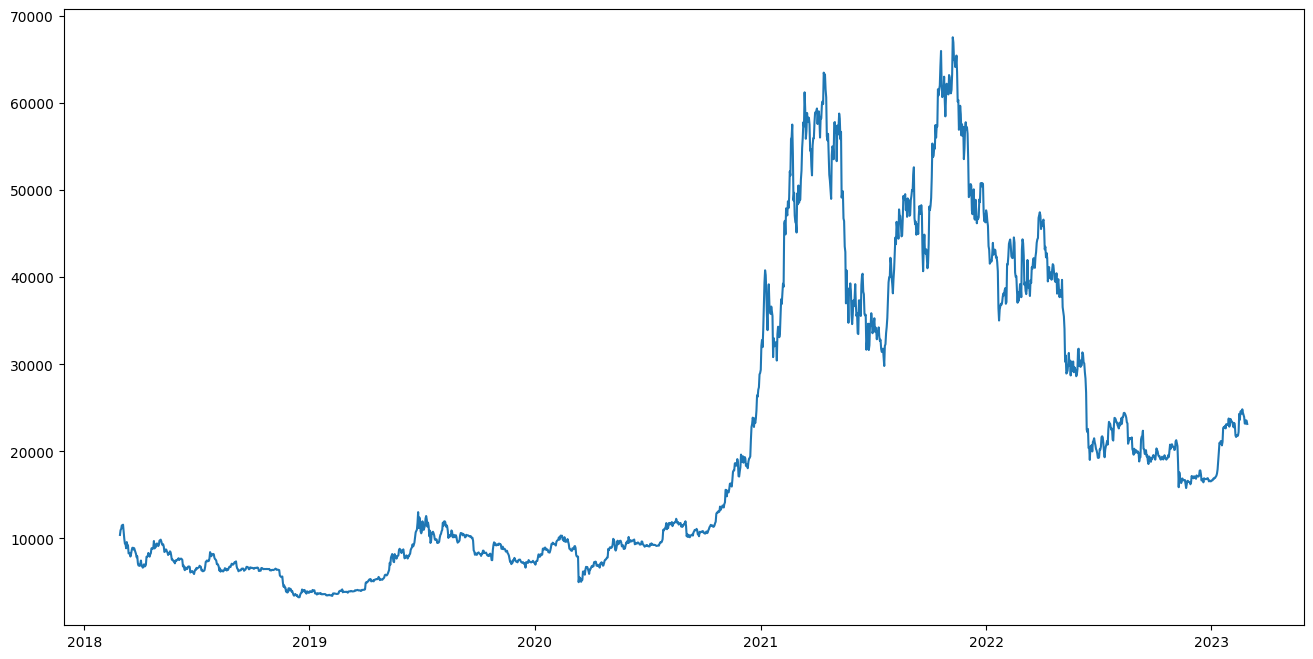

1311/1311 - 26s - loss: 0.0027 - 26s/epoch - 20ms/step
15/15 [==============================] - 1s 15ms/step
2014.8866354965346


C:\Users\hwb_2\AppData\Local\Temp\ipykernel_28308\8311948.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:, 'Predictions'] = closing_price


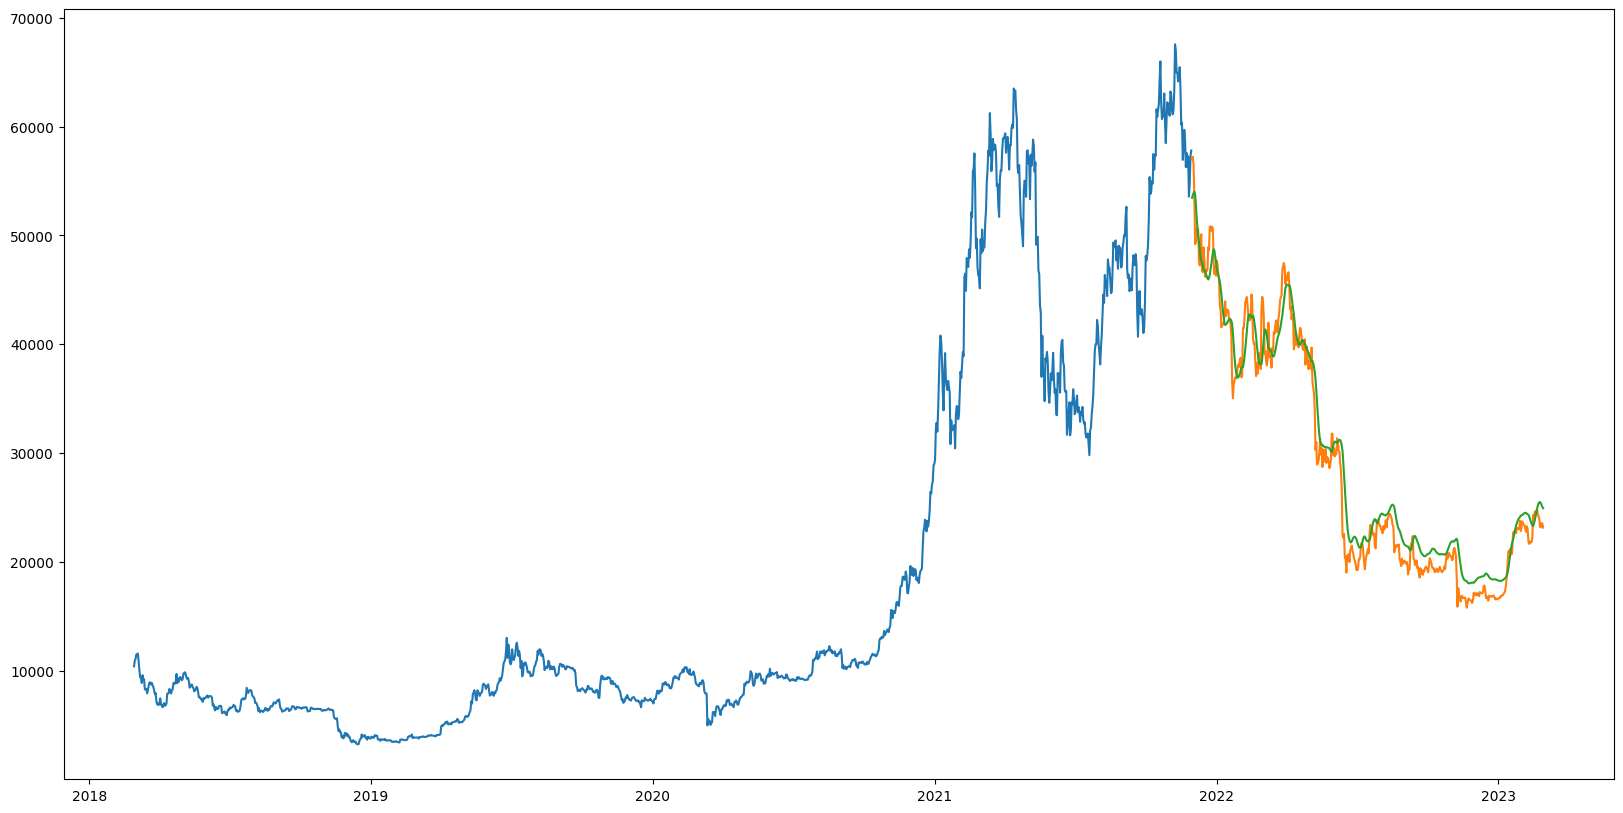

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# read the file
df = pd.read_csv('BTC-USD.csv')

# print the head
df.head()
print(df)

# setting index as date
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

# plot
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price history')
plt.show()

# importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

# creating train and test sets
dataset = new_data.values
train = dataset[0:1371, :]
valid = dataset[1371:, :]

# converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(60, len(train)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i - 60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
rms = np.sqrt(np.mean(np.power((valid - closing_price), 2)))
print(rms)

# for plotting
train = new_data[:1371]
valid = new_data[1371:]
valid.loc[:, 'Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.show()

In [2]:
lstm_model = model

lstm_model.save("saved_model.h5")